### BERT를 이용한 키워드 모델
BERT의 임베딩을 이용해서 받아쓰기한 문서에서 키워드의 점수와 벡터를 얻어내고, 키워드가 문서 내에서 어떻게 바뀌는지 확인해본다.  
(하기 전에 `/Free_Speech/Speech/_data_Project/speech_3T/project_info.json`의 bids_path, audio_path를 `/Free_Speech/speech_3T/_DATA_fMRI`, `/Free_Speech/speech_3T/_DATA_Audio`의 경로로 수정한다.)

In [1]:
# 없을 만한 라이브러리 설치
# Transformer
!pip install -U sentence-transformers

^C


In [1]:
# 텍스트를 불러온다.
import numpy as np
with open("../speech_3T/_DATA_Audio/derivatives/sub-002/sub-002_task-speechTOPIC_run-1_STT_new.txt", 'r', encoding="utf-8") as f:
    text = f.readlines()
    f.close

text[:20]

['친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다.\n',
 '친구는 이름은 유 씨인데 그 친구는 지금 군대가 있습니다.\n',
 '친구는 약간 얼굴이 좀 어두운 색이긴 해요.\n',
 '그리고 이 친구는 머리가 좀 짧아요.\n',
 '그리고 약간 진보 그런 느낌이 나고 얼굴이 조금 긴 것 같아요.\n',
 '그리고 그 친구는 옛날에는 얼굴이 깨끗했는데 갈수록 최근에 마지막으로 봤을 때는 트러블이 좀 있더라고요.\n',
 '그리고 그 친구가 있더라고요.\n',
 '친구는 그리고 제일 중요한 성별을 제가 말을 안 했는데 친구는 남자예요.\n',
 '그리고 친구는 굉장히 좋은 친구예요.\n',
 '제가 중학교 1학년 때부터 알게 된 친구인데 어디 가서 이 친구는 최고의 친구다라고 자신 있게 제가 다른 사람한테 추천했을 정도로 좋은 친구예요.\n',
 '왜 좋냐라고 말하면은 딱히 이유는 잘 모르겠는데 다른 친구들이랑 비교를 해본다고 했을 때 이 친구가 굉장히 좋은 친구다라고 말할 수 있는 아주 특별한 그런 이유는 없는 것 같아요.\n',
 '그렇지만 그냥 무의식적으로 친구랑 같이 있으면 얘랑 있으면 굉장히 마음이 편해져요.\n',
 '그런 친구 성격은 당연하겠지만 좋아요.\n',
 '그 친구는 굉장히 좋은 성격을 가지고 있고 어떻게 좋나면 일단 친절해요.\n',
 '그리고 친절한 거 뭐 당연하고 그리고 굉장히 배려를 세세한 곳에서 잘해주더라고요.\n',
 '예를 들어서 당장 예시가 기억 나진 아마 제가 한번 이런 예시를 지어내 볼게요.\n',
 '예를 들어 어떤 연필 뭔가 이런 걸 빌려주면 뭐 그게 괜찮냐 불편하지 않냐 그걸 써보고 나서 이런 식으로 물어보는 아주 친절한 친구고요.\n',
 '그 친구는 애니메이션을 좋아합니다.\n',
 '그 친구는 그래서 그 친구를 처음에 중1 때는 알지 못했는데 중3 때 그 친구가 애니메이션을 봤던 걸 알았어요.\n',
 '친구는 로 아니면 귀멸의 칼날 이런 애니메이션을 좋아하더라

그런데, 위의 텍스트를 바로 쓸 것은 아니다.  
TR 단위로 키워드를 뽑을 것이기 때문에, 단어의 timestamp가 찍힌 텍스트가 필요하다.  

In [3]:
# "../speech_3T/_DATA_Audio/derivatives/sub-002/sub-002_task-speechTOPIC_run-1_FA_new.txt" 를 불러온다. 이미 존재하는 function을 사용
import sys
sys.path.append("FREE-Speech_path/Speech")
from Speech import tools_Text
Project = "speech_3T"
sub = "002"
task = "speechTOPIC_run-1"
FA = tools_Text.load_FA(Project, sub, task)

FA[:20]

[[11131, 11930, '친구는'],
 [13660, 13970, '여러'],
 [13971, 14150, '명이'],
 [14151, 14550, '있지만'],
 [14740, 15330, '그중에서'],
 [16720, 17010, '가장'],
 [17580, 17965, '친하다고'],
 [17966, 18350, '생각하는'],
 [18380, 18496, '친구'],
 [18497, 18730, '한'],
 [18760, 19030, '명을'],
 [20320, 20605, '묘사해'],
 [20606, 20890, '보라고'],
 [20891, 21490, '하였습니다.'],
 [22320, 23150, '친구는'],
 [23420, 23810, '이름은'],
 [24880, 25030, '유'],
 [25220, 26770, '씨인데'],
 [27320, 27470, '그'],
 [27471, 27604, '친구는']]

In [4]:
# TR을 정의하면 TR 단위로 clustering 해준다.
FA_TR = tools_Text.load_FA(Project, sub, task, TR=1)
FA_TR[:20]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['친구는'],
 [],
 ['여러', '명이'],
 ['있지만', '그중에서'],
 [],
 ['가장'],
 ['친하다고', '생각하는'],
 ['친구', '한', '명을'],
 []]

In [5]:
# 시간은 빼고 단어만 모아둔다.
words = np.array(sum(FA_TR,[]))
words[:10]

array(['친구는', '여러', '명이', '있지만', '그중에서', '가장', '친하다고', '생각하는', '친구', '한'],
      dtype='<U8')

keybert는 키워드가 될 수 있는 후보군의 단어 임베딩과, 키워드를 뽑을 문장의 임베딩이 가장 유사한 후보 단어를 키워드로 지정하는 방법이다.  
미리 딕셔너리(단어들의 모음)를 만들어서 딕셔너리 내 단어들을 키워드의 후보로 할 수 있지만, 여기서는 문장 내의 단어들을 키워드의 후보로 한다.  
</br>

다만, 아무 단어나 키워드가 되면 안된다.
- 먼저 형태소의 단위로 키워드를 뽑을 것이다. 영어야 '단어 하나'='의미 하나'로 매핑이 잘 되지만, 합성어인 한국어는 그렇지 않다. 그래서 의미의 최소 단위인 형태소를 쓰는 것이 좋다.
- 모든 형태소를 쓰면 안된다. 한국어에는 문법의 역할이나, 의미를 단지 보조하는 기능을 하는 형태소가 있기 때문이다.
- 의미가 크지 않은 단어를 쓰면 안된다. ex) _'나는 ~~~라고 생각해'_ 라는 문장의 경우 _'나'_, _'생각'_ 같은 단어들은 의미를 가지는 형태소(명사)이지만 이 문장 자체에선 크게 의미가 없을 수도 있다. 오히려 ~안의 내용이 더 중요하다.

In [6]:
# 먼저 단어들의 형태소 분석을 할 것이다.
doc = " ".join(text) # 문장 단위로 불러온 텍스트를 한 줄로 합친다.

# 형태소 분석기는 정말 종류가 많지만, 여기선 구어 형태소 분석기인 ETRI형태소 분석기를 사용한다.
# https://aiopen.etri.re.kr/guide/WiseNLU
import urllib3
import json
openApiURL = "http://aiopen.etri.re.kr:8000/WiseNLU_spoken"
accessKey = "9d3f4f60-ac44-43c9-9ae4-a3df0ee86686"  # 개인 accessKey
analysisCode = "morp"

# API에 요청할 내용
requestJson = {
"argument": {
    "text": doc,
    "analysis_code": analysisCode
    }
}
# 요청
http = urllib3.PoolManager()
response = http.request(
    "POST",
    openApiURL,
    headers={"Content-Type": "application/json; charset=UTF-8", "Authorization" :  accessKey},
    body=json.dumps(requestJson)
)
# 결과
response_results = response.data.decode('utf-8')
response_results[:4000]

'{"result":0,"return_object":{"doc_id":"","DCT":"","category":"","category_weight":0,"title":{"text":"","NE":""},"metaInfo":{},"paragraphInfo":[],"sentence":[{"id":0,"reserve_str":"","text":"친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다.","morp":[{"id":0,"lemma":"친구","type":"NNG","position":0,"weight":0.0546578},{"id":1,"lemma":"는","type":"JX","position":6,"weight":0.0740639},{"id":2,"lemma":"여러","type":"MM","position":10,"weight":0.0942487},{"id":3,"lemma":"명","type":"NNB","position":17,"weight":0.133569},{"id":4,"lemma":"이","type":"JKS","position":20,"weight":0.0969849},{"id":5,"lemma":"있","type":"VA","position":24,"weight":0.0987483},{"id":6,"lemma":"지만","type":"EC","position":27,"weight":0.0762128},{"id":7,"lemma":"그","type":"MM","position":34,"weight":0.033782},{"id":8,"lemma":"중","type":"NNB","position":37,"weight":0.033782},{"id":9,"lemma":"에서","type":"JKB","position":40,"weight":0.0791261},{"id":10,"lemma":"가장","type":"MAG","position":47,"weight":0.0934605},{"id":11,"le

In [7]:
# response는 텍스트 형식, dictionary형태로 바꾼다.
results = json.loads(response_results)
results.keys()

dict_keys(['result', 'return_object'])

In [8]:
# 이 중 필요한 것은 ['return_object']['sentence']이다.
# 형태소 분석기가 적당히 문장 단위의 결과를 출력해준다.
results = results['return_object']['sentence']
results[0]

{'id': 0,
 'reserve_str': '',
 'text': '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다.',
 'morp': [{'id': 0,
   'lemma': '친구',
   'type': 'NNG',
   'position': 0,
   'weight': 0.0546578},
  {'id': 1, 'lemma': '는', 'type': 'JX', 'position': 6, 'weight': 0.0740639},
  {'id': 2, 'lemma': '여러', 'type': 'MM', 'position': 10, 'weight': 0.0942487},
  {'id': 3, 'lemma': '명', 'type': 'NNB', 'position': 17, 'weight': 0.133569},
  {'id': 4, 'lemma': '이', 'type': 'JKS', 'position': 20, 'weight': 0.0969849},
  {'id': 5, 'lemma': '있', 'type': 'VA', 'position': 24, 'weight': 0.0987483},
  {'id': 6, 'lemma': '지만', 'type': 'EC', 'position': 27, 'weight': 0.0762128},
  {'id': 7, 'lemma': '그', 'type': 'MM', 'position': 34, 'weight': 0.033782},
  {'id': 8, 'lemma': '중', 'type': 'NNB', 'position': 37, 'weight': 0.033782},
  {'id': 9, 'lemma': '에서', 'type': 'JKB', 'position': 40, 'weight': 0.0791261},
  {'id': 10,
   'lemma': '가장',
   'type': 'MAG',
   'position': 47,
   'weight': 0.0934605},
  {'id

In [9]:
# 정말 많은 결과들 중, 형태소 분석을 한 결과만 가져오면 된다.
# 다만 timestamp는 단어 수준으로 되어 있으므로 단어 -> ["형태소1", "형태소2", ...] 이런 식으로 데이터를 저장할 것이다.
tagged_results = []
for sent_result in results:  
    for word in sent_result['morp_eval']:
        word_tag = word['result']
        word_tag = word_tag.split("+")
        word_res = []
        for word in word_tag:
            word_res.append(word.split("/"))
        tagged_results.append(word_res)
        
tagged_results[:10]

[[['친구', 'NNG'], ['는', 'JX']],
 [['여러', 'MM']],
 [['명', 'NNB'], ['이', 'JKS']],
 [['있', 'VA'], ['지만', 'EC']],
 [['그', 'MM'], ['중', 'NNB'], ['에서', 'JKB']],
 [['가장', 'MAG']],
 [['친하', 'VA'], ['다고', 'EC']],
 [['생각하', 'VV'], ['는', 'ETM']],
 [['친구', 'NNG']],
 [['한', 'MM']]]

In [10]:
# 지금까지의 과정을 하나로 합친 function
from Speech import tools_NLP
tokens = sum(tools_NLP.etri_spokentagger(doc,wordlevel=True,stopwords=False),[])  # 단어를 형태소로 분리
tokens = np.array(tokens)
tokens[:10]

C:\Users\Kwon\AppData\Local\Temp/ipykernel_86244/3942718857.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tokens = np.array(tokens)


array([list([['친구', 'NNG'], ['는', 'JX']]), list([['여러', 'MM']]),
       list([['명', 'NNB'], ['이', 'JKS']]),
       list([['있', 'VA'], ['지만', 'EC']]),
       list([['그', 'MM'], ['중', 'NNB'], ['에서', 'JKB']]),
       list([['가장', 'MAG']]), list([['친하', 'VA'], ['다고', 'EC']]),
       list([['생각하', 'VV'], ['는', 'ETM']]), list([['친구', 'NNG']]),
       list([['한', 'MM']])], dtype=object)

이제부턴 키워드를 뽑을 문장을 정의할 것이다.  
TR(=1s)을 기준으로 앞 20TR까지 window로 묶을 것이다. (현재 말하고 있는 내용의 이전 내용을 고려하기 위해)
window를 적용하는 과정에서 두가지를 진행할 것이다.
- 윈도우 적용 문장 / 그 문장의 키워드 후보군을 각각 만든다.
- 키워드 후보군은 명사만 쓰고, 불용어도 제외

</br>

다만, 이 과정에서 문장 단위도 고려할 것이다.  
그냥 size=20TR로 하면 다음과 같은 경우가 생긴다. _'같은 이유로 저는 사형을 찬성합니다. 지금부터는 다음 주제'_   
- 현재 _'주제'_ 라는 단어를 이야기하고 있다면 이 _'주제'_ 라는 단어의 진정한 의미는 문장의 종료 시점까지 있어야 알 수 있다. 즉, 현재 말하고 있는 단어의 이전 시점에 언급되었던 단어도 중요하지만, 이후에 말해질 단어도 중요하다.
- 만약 위 같은 window를 그냥 쓴다면, 이렇게 될 수도 있다.
    -  _'그래서 위와 같은 이유로 저는 사형을 찬성합니다.'_         -> _'사형'_
    -  _'위와 같은 이유로 저는 사형을 찬성합니다. 지금부터는'_     -> _'사형'_
    - _'같은 이유로 저는 사형을 찬성합니다. 지금부터는 다음 주제'_ -> _'사형'_
    - _'사형을 찬성합니다. 지금부터는 다음 주제 친구들에 대해서'_  -> _'사형'_
    - _'지금부터는 다음 주제 친구들에 대해서 이야기를 해 보도록'_  -> _'친구'_
- 모델이 뽑은 키워드의 전환 시점이 실질적인 키워드 전환보다 느려질 수 있다.
- 그래서 현재 말하고 있는 단어의 의미가 충분히 반영될 수 있도록 현재 단어를 포함하는 문장까지는 window에 포함될 수 있도록 할 것이다.

In [11]:
# 위를 고려하려면 텍스트를 문장으로 나눠야 한다.
# 근데 구어체를 그냥 문장 단위로 나누면 그 길이가 너무 길어진다. ex) ~했는데 ~해서 ... 이러면 문장이 끝나지 않는다.
# 그래서 종속되지 않은 절 단위로 문장을 끊을 것이다.
# https://aiopen.etri.re.kr/demo/WiseNLU 의존구문분석을 이용한다. (단어의 문장에서의 역할을 출력해준다고 생각하면 된다.)
dparse_results = tools_NLP.etri_dparse(doc) # ETRI형태소 분석기는 의존구문분석도 해준다(문어체만). 사용 방법이 위의 형태소 분석과 완전 동일하므로 그냥 미리 만들어진 function을 쓴다.

# 구문 분석 결과만 출력하자면,
dparse_results[0]['phrase_dependency']

[{'id': 0,
  'label': 'NP_SBJ',
  'text': '친구는',
  'begin': 0,
  'end': 0,
  'key_begin': 0,
  'head_phrase': 5,
  'sub_phrase': [],
  'weight': 0,
  'element': []},
 {'id': 1,
  'label': 'NP_SBJ',
  'text': '여러 명이',
  'begin': 1,
  'end': 2,
  'key_begin': 1,
  'head_phrase': 2,
  'sub_phrase': [],
  'weight': 0,
  'element': []},
 {'id': 2,
  'label': 'S',
  'text': 'P#1@SBJ이 있지만',
  'begin': 1,
  'end': 3,
  'key_begin': 3,
  'head_phrase': 5,
  'sub_phrase': [1],
  'weight': 0,
  'element': []},
 {'id': 3,
  'label': 'NP_AJT',
  'text': '그중에서',
  'begin': 4,
  'end': 4,
  'key_begin': 4,
  'head_phrase': 5,
  'sub_phrase': [],
  'weight': 0,
  'element': []},
 {'id': 4,
  'label': 'AP',
  'text': '가장',
  'begin': 5,
  'end': 5,
  'key_begin': 5,
  'head_phrase': 5,
  'sub_phrase': [],
  'weight': 0,
  'element': []},
 {'id': 5,
  'label': 'S_CMP',
  'text': 'P#0@SBJ는 S#2@S지만 P#3@AJT에서 P#4@AP가장 친하다고',
  'begin': 0,
  'end': 6,
  'key_begin': 6,
  'head_phrase': 6,
  'sub_phrase': [0

In [12]:
# 문장이 여러 독립절로 이뤄진 경우 문장의 종료 시점을 "S"라고 라벨링 해준다.
# 따라서 "S"라고 라벨이 붙은 시점을 찾으면 된다.

# 절 단위로 나누기
line_start = 0
phrase = []      # 절  <-  결과 확인 용도이지 실질적으론 아래의 절 끝 인덱스만 쓴다.
phrase_end = []  # 절의 맨 끝 인덱스 (즉, words[end[i]+1:end[i+1]+1]이 한 절)
dparse_results = tools_NLP.etri_dparse(doc)
for line in dparse_results:
    word_index = np.arange(len(line["word"]))+line_start
    line_words = [word["text"] for word in line["word"]]
    phrase_begin = 0
    for phrase_tag in line['phrase_dependency']:
        if phrase_tag['label'] == "S":
            phrase.append(" ".join(line_words[phrase_begin:phrase_tag['end']+1]))
            phrase_end.append(phrase_tag["end"]+line_start)

            phrase_begin = phrase_tag['end']+1
    
    # 결과가 단 하나의 문장으로만 이뤄진 경우 문장 끝에 'S'라벨이 없는 경우가 있으므로 그냥 추가
    if len(phrase) < 1:
        phrase.append(" ".join(line_words[phrase_begin:]))
        phrase_end.append(word_index[-1])
    elif phrase[-1].split()[-1] != line_words[-1]:
        phrase.append(" ".join(line_words[phrase_begin:]))
        phrase_end.append(word_index[-1])

    # 현재 줄의 단어 인덱스 업데이트
    line_start += len(line["word"])

phrase_end = np.array(phrase_end)


print(phrase_end[:10])
phrase[:10]

[ 3 13 17 22 28 29 35 41 46 52]


['친구는 여러 명이 있지만',
 '그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다.',
 '친구는 이름은 유 씨인데',
 '그 친구는 지금 군대가 있습니다.',
 '친구는 약간 얼굴이 좀 어두운 색이긴',
 '해요.',
 '그리고 이 친구는 머리가 좀 짧아요.',
 '그리고 약간 진보 그런 느낌이 나고',
 '얼굴이 조금 긴 것 같아요.',
 '그리고 그 친구는 옛날에는 얼굴이 깨끗했는데']

In [13]:
# 형태소 분석 / 절 분석 모두 단어의 인덱스를 이용하므로 단어의 인덱스를 TR 단위로 clustering
TR_index = []
word_number = 0
for TR in FA_TR:
    index = []
    for word in TR:
        index.append(word_number)
        word_number += 1
    TR_index.append(index)
TR_index[:20]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [0],
 [],
 [1, 2],
 [3, 4],
 [],
 [5],
 [6, 7],
 [8, 9, 10],
 []]

In [14]:
# 윈도우 적용하는 parameter
window_size = 20   # 윈도우 크기
is_verb = False    # 키워드 후보 중 동사 포함 유무  


# 솎아낼 불용어들
stopword = tools_NLP.load_stopword([["생각", "NNG"],["나", "VV"],["생각하", "VV"],["들", "VV"]])
stopword.remove(["없", "VA"])


# 키워드가 될 형태소
if is_verb: tag=['NNG', 'NNP', 'NR', 'VV', 'VA']
else: tag=['NNG', 'NNP', 'NR']

In [15]:
# 지금부터 윈도우 적용
window_token = []
window_sentence = []

# window대로 clustering
for TR in range(len(FA_TR)):
    # window
    window_l = TR-window_size+1
    if window_l<0: window_l = 0
    
    # window 내 단어들
    window_index = sum(TR_index[window_l:TR+1],[])  # window: [t-window_size, t]
    
    if len(window_index) > 0: # 빈 window가 아닐경우
        # 윈도우의 오른쪽 끝을 현재 단어를 포함하는 구가 포함되도록 변경
        index_r = phrase_end[phrase_end>=np.max(window_index)][0]
        
        # 만약 현 TR에 문장 끝이 포함 -> 윈도우의 오른쪽 끝이 현 문장 끝으로
        for index in TR_index[TR]: 
            if index in phrase_end: index_r = index
        
        index_l = window_index[0]
        
        all_tokens = sum(tokens[index_l:index_r+1],[])
        token_prun = []

        # 형태소 솎기
        for token in all_tokens:
            if token[1] in tag:
                if token not in stopword:
                    if token[1] in ["VV", "VA"]:
                        token_prun.append(token[0]+"다")  # 용언의 경우 기본형으로 바꿔서 사용
                    else:
                        token_prun.append(token[0])
        window_token.append(token_prun)
        window_sentence.append(' '.join(words[index_l:index_r+1]))
    else:
        window_token.append([])
        window_sentence.append([])
window_sentence[20:40]

['친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다.',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다.',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데 그 친구는 지금 군대가 있습니다.',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데 그 친구는 지금 군대가 있습니다.',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데 그 친구는 지금 군대가 있습니다.',
 '친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데 그 친구는 지금 군대가 있습니다. 친구는 약간 얼굴이 좀 어두운 색이긴',
 '여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. 친구는 이름은 유 씨인데 그 친구는 지금 군대가 있습니다. 친구는 약간 얼굴이 좀 어두운 색이긴',
 '여러 명이 있지만 그중에서 가장

이제는 윈도우 내에서 키워드를 뽑는다.

In [16]:
# 예시 윈도우 하나만 키워드를 뽑아보자
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# BERT 모델
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

# 중요한 파라메터
n_gram_range = (1, 1)  # 키워드(구)를 만들 수 있는 단어 개수

# 키워드 후보를 생성
count = CountVectorizer(ngram_range=n_gram_range).fit([" ".join(set(window_token[20]))]) 
candidates = count.get_feature_names_out()  # 모든 단어 조합 -> keyword candidate
doc_embedding = model.encode(window_sentence[20])  # 원본 문장 embedding
candidate_embeddings = model.encode(candidates)   # keyword candidate embedding
word_doc_sim = cosine_similarity(candidate_embeddings,
                                doc_embedding.reshape(1,768))  # 키워드 후보 & 원문의 유사도
word_word_sim = cosine_similarity(candidate_embeddings)  # 키워드 후보 끼리의 유사도
            
keywords_idx = [np.argmax(word_doc_sim)]  # 최고의 키워드 인덱스

print(window_sentence[20]+" -> "+candidates[keywords_idx])

c:\Users\Kwon\anaconda3\envs\FS_EPI\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['친구는 여러 명이 있지만 그중에서 가장 친하다고 생각하는 친구 한 명을 묘사해 보라고 하였습니다. -> 친구']


In [17]:
# 모든 윈도우에 대해서 실행
min_word = 1
max_word = 1
res = tools_NLP.keyword_extraction(model, window_sentence, window_token, min_word, max_word, 1, print_keywords=False)

# 결과의 임베딩과 키워드 
res_embed = []
res_keys = []
res_scores = []
for res_tr in res:
    # 키워드 하나만 뽑는다고 할때
    res_keys.append(res_tr[0][0]) 
    if len(res_tr[0][0]) > 0: res_embed.append(model.encode(res_tr[0][0]))
    else: res_embed.append(np.zeros(768))
    res_scores.append(res_tr[0][1])
res_embed = np.array(res_embed)

no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword
no candidate, just return NO keyword


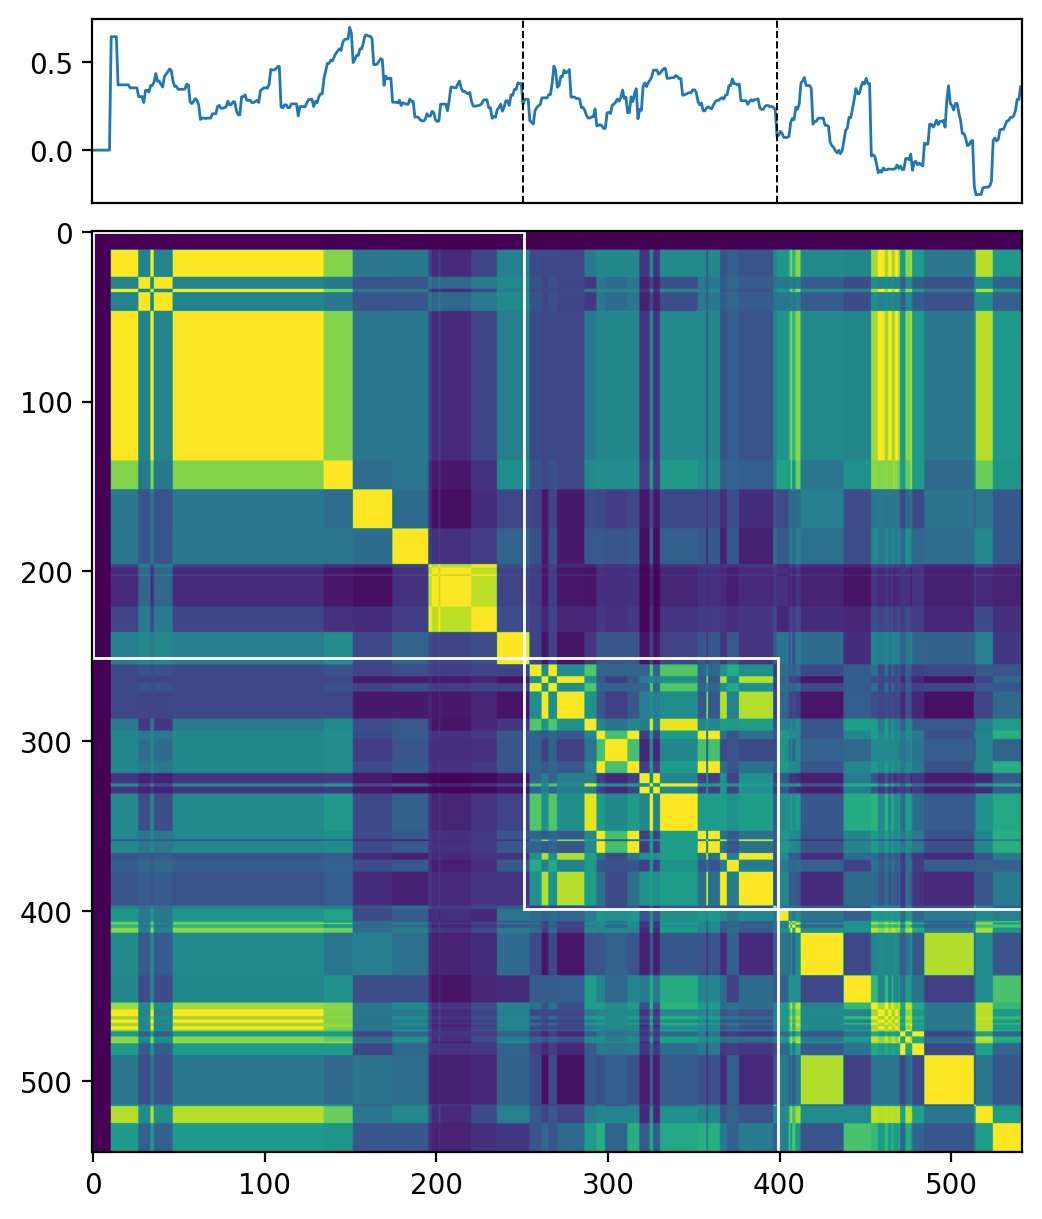

In [19]:
# 시각화
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec

# 피험자가 나눈 주제 변환 시점
times = tools_Text.load_FA(Project, sub, task)
times = np.round(np.array(times)[:,:2].astype(int)/1000).astype(int)
ev_end = tools_Text.load_audio_boundary(Project, sub, task, "ev1")

ev = []
for t in ev_end:
    try: ev.append(times[np.where(times[:,1]==t)[0][-1]+1,0])
    except: pass

ev.sort()
ev = [0]+ev+[len(FA)]

fig = plt.figure(figsize=(6,7.5), dpi=200)

gs = gridspec.GridSpec(2, 1, height_ratios=[0.2, 1])
axes = [fig.add_subplot(gs[0,0]),
        fig.add_subplot(gs[1,0])]

axes[0].plot(res_scores, linewidth=1)
for t in ev:
    axes[0].axvline(t, c="k", linestyle="--", linewidth=0.7)
axes[0].set_xlim([0,len(res)])
axes[0].set_xticks([])
axes[1].imshow(cosine_similarity(res_embed), aspect="auto")

for i in range(len(ev)-1):
    rect = patches.Rectangle(
        (ev[i],ev[i]),
        ev[i+1]-ev[i],
        ev[i+1]-ev[i],
        linewidth=1,edgecolor='w',facecolor='none'
    )
    axes[1].add_patch(rect)
plt.subplots_adjust(hspace=0.05)
plt.show()



In [42]:
# 결과 출력해보기
for TR in range(len(FA_TR)):
    print("{0:<20} -> {1}".format(' '.join(FA_TR[TR]).strip(),res_keys[TR]))

                     -> 
                     -> 
                     -> 
                     -> 
                     -> 
                     -> 
                     -> 
                     -> 
                     -> 
                     -> 
                     -> 
친구는                  -> 친구
                     -> 친구
여러 명이                -> 친구
있지만 그중에서             -> 친구
                     -> 친구
가장                   -> 친구
친하다고 생각하는            -> 친구
친구 한 명을              -> 친구
                     -> 친구
묘사해 보라고 하였습니다.       -> 친구
                     -> 친구
친구는                  -> 친구
이름은                  -> 친구
유                    -> 친구
씨인데                  -> 친구
                     -> 친구
그 친구는 지금 군대가         -> 군대
있습니다.                -> 군대
                     -> 군대
친구는                  -> 군대
                     -> 군대
                     -> 군대
약간 얼굴이               -> 군대
좀                    -> 친구
어두운 색이긴              -> 친구
해요.                  -> 군대
                     ->